In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
# custom dataset loading
import torch
import torchvision
import torchdata as td
import os
import PIL
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from skimage import io, transform
import pandas as pd
from torchvision.io import read_image
from skimage import data, io
from matplotlib import pyplot as plt
from custom_dataset import CougDataset
from torch.utils.data import DataLoader

#### following a cifar10 tutorial and adapting to binary coug/notcoug classification
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [18]:
BATCH_SIZE = 4
NUM_WORKER = 2
IMAGE_SIZE = 64

img_dir = "D:\\data\\magcougdataset\\cougnotcoug"
project_dir = 'D:\\projects\\ahmedpytorch'

data_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(IMAGE_SIZE, max_size=IMAGE_SIZE * 2),
        transforms.RandomCrop(IMAGE_SIZE, pad_if_needed=True),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

full_dataset = CougDataset(img_dir=img_dir, transform=data_transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size


train_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size]
)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER
)


classes = ('notcoug', 'coug')

print(f"train_size: {train_size}, test_size: {test_size}")

print(
    "The shape of tensor for 50th image in train dataset: ",
    train_dataset[49][0].shape,
)
print("The label for 50th image in train dataset: ", train_dataset[49][1])

train_size: 3712, test_size: 928
The shape of tensor for 50th image in train dataset:  torch.Size([3, 64, 64])
The label for 50th image in train dataset:  0


In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.034
[1,   200] loss: 0.032
[1,   300] loss: 0.031
[1,   400] loss: 0.031
[1,   500] loss: 0.033
[1,   600] loss: 0.033
[1,   700] loss: 0.031
[1,   800] loss: 0.030
[1,   900] loss: 0.029
[2,   100] loss: 0.030
[2,   200] loss: 0.029
[2,   300] loss: 0.028
[2,   400] loss: 0.028
[2,   500] loss: 0.029
[2,   600] loss: 0.026
[2,   700] loss: 0.027
[2,   800] loss: 0.027
[2,   900] loss: 0.026
Finished Training


In [25]:
PATH = f"{project_dir}\\coug.pth"
torch.save(net.state_dict(), PATH)

In [26]:
dataiter = iter(train_loader)

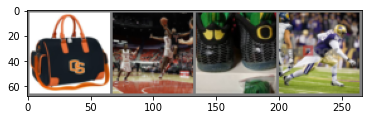

notcoug coug  notcoug notcoug


In [27]:
images, labels = dataiter.next()
grid = torchvision.utils.make_grid(images).numpy()
grid = grid / 2 + 0.5
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


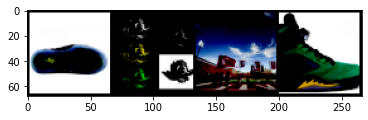

GroundTruth:  notcoug notcoug coug  notcoug
Predicted:  notcoug notcoug notcoug notcoug


In [33]:
net = Net()
net.load_state_dict(torch.load(PATH))

images, labels = dataiter.next()

grid = torchvision.utils.make_grid(images).numpy()

plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(BATCH_SIZE)))

In [34]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 74 %


In [35]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: notcoug is 80.6 %
Accuracy for class: coug  is 62.3 %
